In [1]:
import numpy as np
from Bio import SeqIO
from collections import defaultdict
from copy import deepcopy
import networkx as nx 
import matplotlib.pyplot as plt 

In [16]:


np.random.seed(0)

nucleotides = ['A', 'T', 'G', 'C']

sequence_string = ''.join(np.random.choice(nucleotides, 1000).tolist())
reads = ''

for i in range(1, 1001):
    read_len = 150
    read_start = np.random.default_rng().integers(0, 1000 - read_len)
    read_str = sequence_string[read_start:read_start+read_len]
    reads += f'>READ_SEQ_{i}\n{read_str}\n'

with open(f"reads.fasta", "w") as file:
    file.write(reads)

with open("sequense.fasta", "w") as file:
    file.write('>MAIN_SEQ_0\n')
    file.write(sequence_string)

## Построение графа Де Брюина
По заданному набору ридов в формате FASTQ и параметру k, который соответствует длине k-меров, построить граф Де Брюина, некоторый путь в котором соответствовал бы возможной подстроке в исходном геноме. Не забывайте про запоминание покрытия каждого k-мера, а так же про сами подстроки, которые соответствуют каждому ребру. В остальном граф полностью соответствует тому, что был описан в лекции.

In [2]:
seq_name, seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/reads.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        seq_name.append(str(seq_record.name))
        seq_string.append(str(seq_record.seq))

true_seq_name, true_seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/sequense.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        true_seq_name.append(str(seq_record.name))
        true_seq_string.append(str(seq_record.seq))
true_seq = true_seq_string[0]

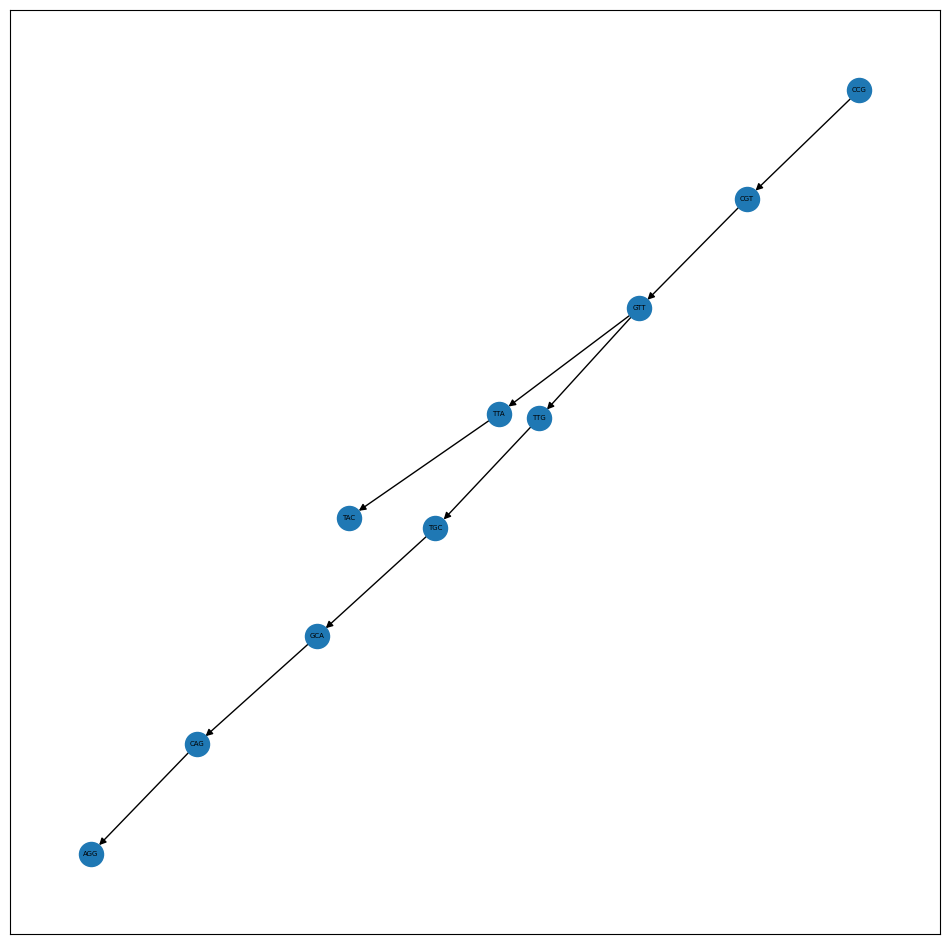

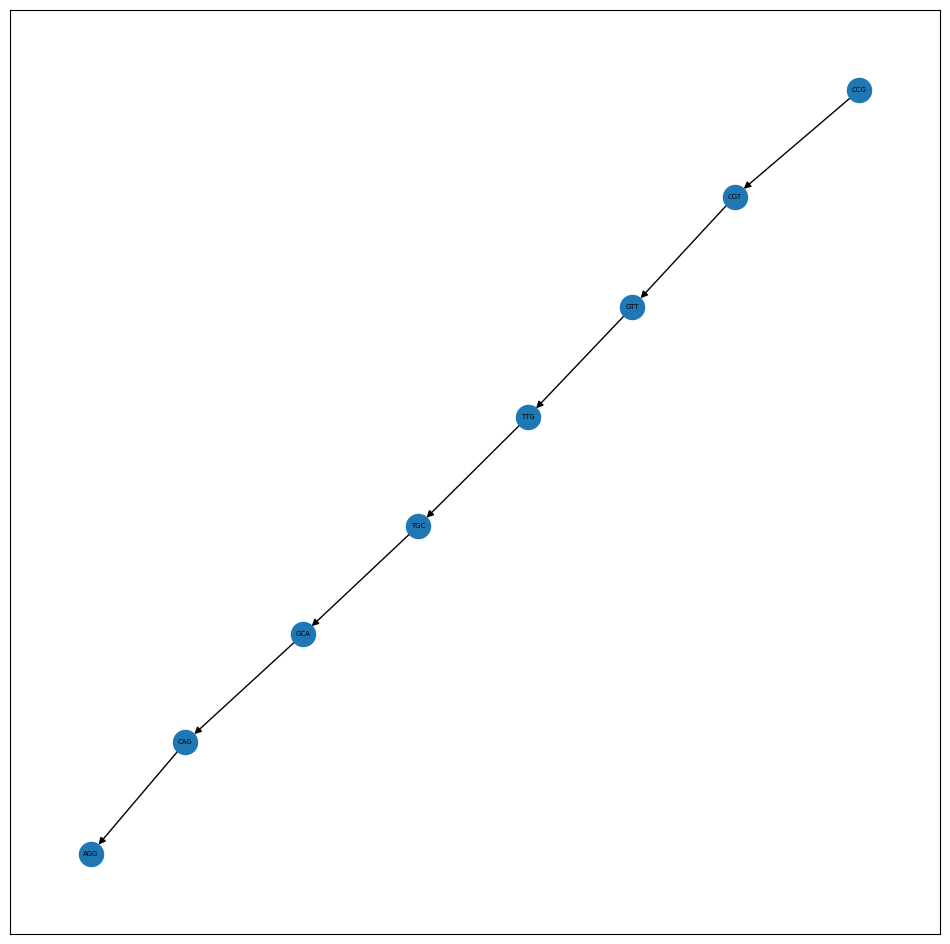

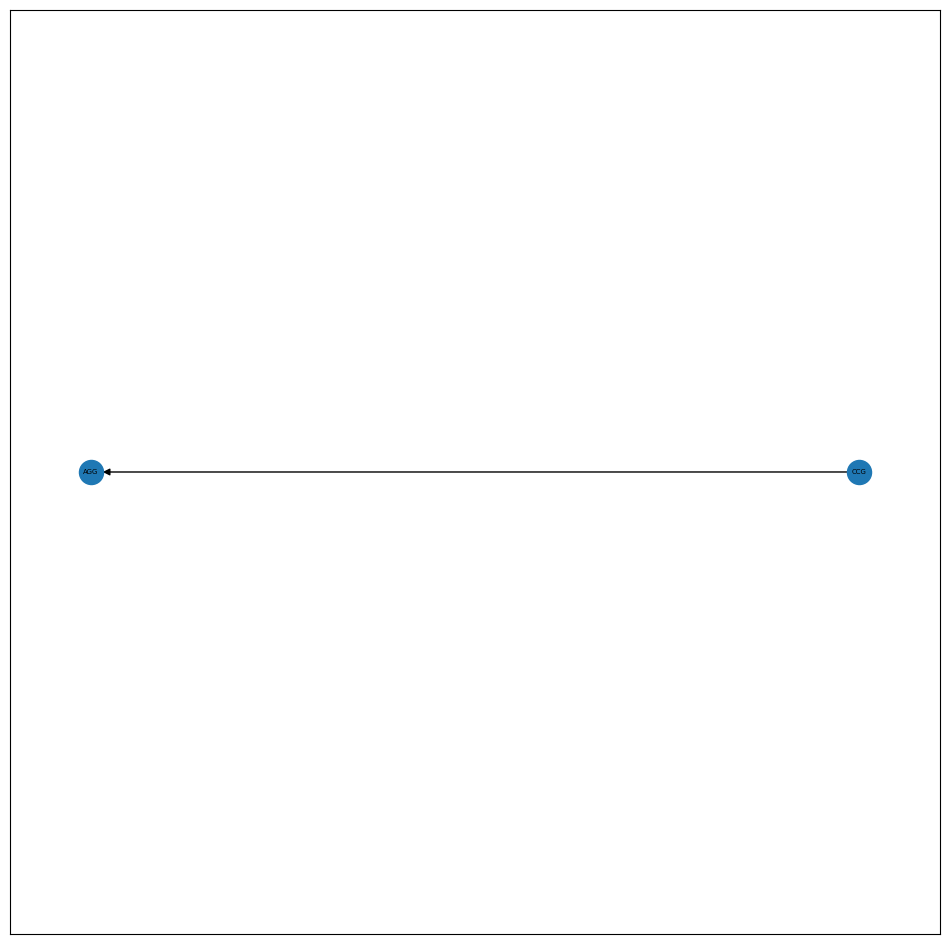

In [139]:
class Node():
    def __init__(self, string):
        self.string = string
        self.in_degree = 0
        self.out_degree = 0
        self.is_compacted = False

class Edge():
    def __init__(self, prev_node, next_node, string, coverage=1):
        self.prev_node = prev_node
        self.next_node = next_node
        self.string = string
        self.coverage = coverage

class DBGraph():
    def __init__(self, reads, k):
        self.reads = reads
        self.k = k
        self.used_edges = set()
        self.used_nodes = set()
        self.nodes = {}
        self.edges = {}
        self.connections = defaultdict(list)
        self.kmers = []
        self.compacted = False
        self.deleted_tails = False
        self.string = None

    def gen_kmers(self):
        for read in self.reads:
            self.kmers.extend([read[i:self.k+i] for i in range(0, len(read)-self.k+1)])

    def create_graph(self):
        for kmer in self.kmers:
            prev_node_str = kmer[:-1]
            if prev_node_str not in self.used_nodes:
                self.nodes[prev_node_str] = Node(prev_node_str)
                self.used_nodes.add(prev_node_str)
                # self.nodes[prev_node_str].out_degree += 1

            next_node_str = kmer[1:]
            if next_node_str not in self.used_nodes:
                self.nodes[next_node_str] = Node(next_node_str)
                self.used_nodes.add(next_node_str)
                self.nodes[next_node_str].in_degree += 1
                if prev_node_str in self.used_nodes:
                    self.nodes[prev_node_str].out_degree += 1

            if kmer in self.used_edges:
                self.edges[kmer].coverage += 1
            else:
                self.used_edges.add(kmer)
                self.edges[kmer] = Edge(prev_node_str, next_node_str, kmer)
                self.connections[prev_node_str].append(self.edges[kmer])

    def compact(self):
        if self.compacted:
            print('This graph has already been compacted')
            return
        self.compacted = True
        for node in self.nodes:
            # print(node)
            # print(self.nodes[node].in_degree)
            # print(self.nodes[node].out_degree)
            if not self.nodes[node].is_compacted:
                self.nodes[node].is_compacted = True
                if self.nodes[node].out_degree > 0:
                    for new_edge_idx in range(len(self.connections[node])):
                        new_edge = self.connections[node][new_edge_idx]
                        next_edge = new_edge
                        while self.nodes[next_edge.next_node].out_degree == 1:
                            prev_edge = new_edge
                            next_edge = self.connections[new_edge.next_node][0]
                            new_edge_string = prev_edge.string + next_edge.string[-1]
                            new_edge_coverage = int(len(prev_edge.string)/len(new_edge_string)*prev_edge.coverage + len(next_edge.string)/len(new_edge_string)*next_edge.coverage)
                            self.nodes[prev_edge.next_node].is_compacted = True
                            new_edge = Edge(node, next_edge.next_node, new_edge_string, new_edge_coverage)
                            del self.connections[prev_edge.next_node]
                        self.connections[new_edge.prev_node][new_edge_idx] = new_edge

    def _find_tails(self, v):
        for edge in self.connections_temp[v]:
            if edge.coverage:
                edge.coverage -= 1
                if self.nodes[edge.next_node].out_degree == 1 and edge.next_node not in self.nodes_in_tail:
                    prev_start_node = edge.prev_node
                    start_node = edge.next_node
                    edge_temp = edge
                    tail_coverage = 0
                    tail_len = 0
                    while True:
                        if len(self.connections_temp[edge_temp.next_node]) > 1:
                            break
                        tail_len += 1
                        tail_coverage += edge_temp.coverage
                        if len(self.connections_temp[edge_temp.next_node]) == 0:
                            self.tails[(prev_start_node, start_node)] = tail_len*tail_coverage
                            break
                        edge_temp = self.connections[edge_temp.next_node][0]
                        self.nodes_in_tail.add(edge_temp.prev_node)
                self._find_tails(edge.next_node)

    def delete_tails(self):
        if self.deleted_tails:
            print('Tails have already been deleted')
            return
        self.delete_tails = True
        self.nodes_in_tail = set()
        self.tails = {}
        in_degrees = [self.nodes[i].in_degree for i in self.connections.keys()]
        nodes_min_in_degrees = [list(self.connections.keys())[i] for i in range(len(in_degrees)) if in_degrees[i] == min(in_degrees)]
        self.connections_temp = deepcopy(self.connections)
        for start in nodes_min_in_degrees:
            self._find_tails(start)
        if len(self.tails) > 1:
            tails_min_scores = set(np.sort(list(self.tails.values()))[:int(len(self.tails)*0.3)+1])
            for tail in self.tails:
                if self.tails[tail] in tails_min_scores:
                    self.connections[tail[0]] = [edge for edge in self.connections[tail[0]] if edge.next_node != tail[1]]
                    self.nodes[tail[0]].out_degree = len(self.connections[tail[0]])
                    edge = self.connections[tail[1]][0]
                    while self.nodes[edge.next_node].out_degree != 0:
                        del self.connections[edge.next_node]
                        del self.nodes[edge.next_node]
                        edge = self.connections_temp[edge.next_node][0]
                    del self.connections_temp[edge.next_node]
                    del self.connections[tail[1]]
                    del self.nodes[tail[1]]

    def _print_connections(self):
        for node in self.connections:
            print(node)
            print(self.connections[node])
            print()

    def _find_euler_path(self, v):
        for edge in self.connections_temp[v]:
            if edge.coverage:
                edge.coverage -= 1
                self.string += edge.string[(self.k-1):]
                self._find_euler_path(edge.next_node)

    def assemble(self, multiple_start=False):
        in_degrees = [self.nodes[i].in_degree for i in self.connections.keys()]
        nodes_min_in_degrees = [list(self.connections.keys())[i] for i in range(len(in_degrees)) if in_degrees[i] == min(in_degrees)]
        if multiple_start:
            for start in nodes_min_in_degrees:
                self.connections_temp = deepcopy(self.connections)
                self.string = self.connections[start][0].string[:(self.k-1)]
                self._find_euler_path(start)
        else:
            start = nodes_min_in_degrees[0]
            self.connections_temp = deepcopy(self.connections)
            self.string = self.connections[start][0].string[:(self.k-1)]
            self._find_euler_path(start)
        return self.string
    
    def visualize(self, show_edges=False, layout=nx.kamada_kawai_layout):
        G = nx.DiGraph() 
        for node in self.connections:
            for edge in self.connections[node]:
                G.add_edge(edge.prev_node, edge.next_node, string=edge.string)
        pos = layout(G)
        plt.figure(figsize=(12,12))
        nx.draw_networkx(G, pos, font_size=5)
        if show_edges:
            nx.draw_networkx_edge_labels(G, pos, font_size=8)
        plt.show()

    def get_statistics(self):
        edge_coverage = []
        node_degrees = []
        n_edges = 0
        n_nodes = 0
        for node in self.connections:
            node_degrees.append(self.nodes[node].in_degree + self.nodes[node].out_degree)
            n_nodes += 1
            for edge in self.connections[node]:
                edge_coverage.append(edge.coverage)
                n_edges += 1
        print('Number edges:', n_edges)
        print('Number nodes:', n_nodes)
        figure, axis = plt.subplots(1, 2) 
        axis[0].hist(edge_coverage)
        axis[0].set_title('Edge coverage')
        axis[0].set_xticks(np.arange(1, max(edge_coverage)+1))
        axis[1].hist(node_degrees)
        axis[1].set_title('Node degrees')
        axis[1].set_xticks(np.arange(1, max(node_degrees)+1))
        plt.show()
    
    def get_shared_motif(self, true_seq):
        if not self.string:
            print('Do assemble first!')
            return
        s_seq = self.string if len(self.string) <= len(true_seq) else true_seq
        l_seq = self.string if len(self.string) > len(true_seq) else true_seq
        motif = set()
        for i in range(len(s_seq)):
            for j in range(i+1, len(s_seq)+1):
                motif.add(s_seq[i:j])
        update_motif = list(motif)
        for m in update_motif:
            if m not in l_seq:
                motif.remove(m)
        motif = list(motif)
        longest_motif = motif[np.argmax([len(i) for i in motif])]
        print('Longest shared motif is:', longest_motif, end='\n\n\n')

        

true_seq_1 = 'AGATGAATGGACCGGCCATATAAGTAAG'
test_sequences = ['CCGTTG', 'CGTTAC', 'GTTGCA', 'TGCAGG']


G = DBGraph(test_sequences, 4)
G.gen_kmers()
G.create_graph()
s1 = true_seq_1
s2 = G.assemble()
G.visualize(show_edges=False, layout=nx.kamada_kawai_layout)
G.delete_tails()
# print(s1)
# print(s2)
# print()
G.visualize(show_edges=False, layout=nx.kamada_kawai_layout)
# G.get_statistics()
# G.get_shared_motif(s1)
# G.visualize(show_edges=False, layout=nx.kamada_kawai_layout)



G.compact()
# s1 = true_seq
# s2 = G.assemble()
# print(s1)
# print(s2)
# print()
G.visualize(show_edges=False, layout=nx.kamada_kawai_layout)
# G.get_statistics()
# G.get_shared_motif(s1)

## Сжатие графа  
Научитесь производить сжатие графа Де Брюина. При сжатии не забывайте склеивать подстроки на ребрах и обновлять покрытие ребер. Пересчитывайте покрытие склеиваемых ребер как взвешенное среднее, где вес соответствует длине подстроки, соответствующей ребру.